In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import datetime as dt
import ta
import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [2]:
STOCK_TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2024-06-01" 
LOOK_BACK_DAYS = 60      # Number of past days to consider for prediction (timesteps)
PREDICTION_DAYS = 30     # Days to reserve for the test set (from end of data)
EPOCHS = 100             
BATCH_SIZE = 32
LSTM_UNITS = 50          
DROPOUT_RATE = 0.3       
CNN_FILTERS = 64         
CNN_KERNEL_SIZE = 3 
LEARNING_RATE = 0.0005   

# Early Stopping parameters
PATIENCE = 20            
MIN_DELTA = 0.001 

In [24]:
MODEL_SAVE_PATH = 'models/stock_prediction_model.keras' 
SCALER_SAVE_PATH = 'models/feature_scaler.pkl'
TARGET_SCALER_SAVE_PATH = 'models/target_scaler.pkl'

In [4]:
try:
    data = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
    if data.empty:
        raise ValueError("No data fetched. Check ticker or date range.")
    print("Data fetched successfully.")
    df = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

    # Flatten MultiIndex Columns if they exist ---
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns.values]
        df.rename(columns={'Open_AAPL': 'Open', 'High_AAPL': 'High', 'Low_AAPL': 'Low', 
                           'Close_AAPL': 'Close', 'Volume_AAPL': 'Volume'}, inplace=True)
        print("Flattened MultiIndex columns.")

except Exception as e:
    print(f"Error fetching data: {e}")
    print("Exiting.")
    exit()
print(df.columns)
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data fetched successfully.
Flattened MultiIndex columns.
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431898,6.446625,6.382910,6.414467,493729600
2010-01-05,6.443018,6.479384,6.409057,6.449631,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328809,6.371487,6.282827,6.363973,477131200
2010-01-08,6.370887,6.371489,6.283130,6.320396,447610800
...,...,...,...,...,...
2024-05-24,189.095657,189.692870,187.164685,187.941069,36294600
2024-05-28,189.105621,192.101605,188.219765,190.618535,52280100


In [5]:
# Moving Averages
df['SMA_10'] = ta.trend.sma_indicator(df['Close'], window=10)
df['EMA_10'] = ta.trend.ema_indicator(df['Close'], window=10)
df['SMA_50'] = ta.trend.sma_indicator(df['Close'], window=50)
df['EMA_50'] = ta.trend.ema_indicator(df['Close'], window=50)

# RSI (Relative Strength Index)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)

# MACD (Moving Average Convergence Divergence)
macd = ta.trend.macd(df['Close'])
df['MACD'] = macd
df['MACD_Signal'] = ta.trend.macd_signal(df['Close'])
df['MACD_Diff'] = ta.trend.macd_diff(df['Close'])

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
df['BB_High'] = bollinger.bollinger_hband()
df['BB_Low'] = bollinger.bollinger_lband()
df['BB_Mid'] = bollinger.bollinger_mavg()
df['BB_Width'] = bollinger.bollinger_wband()

# Volatility (Annualized Standard Deviation of Log Returns)
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Volatility_20'] = df['Log_Return'].rolling(window=20).std()

In [6]:
news_df = pd.read_csv('data/aapl_news.csv')
news_df['publish_datetime'] = pd.to_datetime(news_df['publish_datetime'], errors='coerce')
news_df = news_df.dropna(subset=['publish_datetime'])

# Extract date only
news_df['date'] = news_df['publish_datetime'].dt.date

# Group by date and compute average sentiment
sentiment_df = news_df.groupby('date').agg({
    'compound_score': 'mean',
    'positive_score': 'mean',
    'negative_score': 'mean',
    'neutral_score': 'mean'
}).reset_index()

# Rename columns for clarity
sentiment_df.rename(columns={
    'compound_score': 'sentiment_compound',
    'positive_score': 'sentiment_positive',
    'negative_score': 'sentiment_negative',
    'neutral_score': 'sentiment_neutral',
    'date':'Date'
}, inplace=True)
sentiment_df.columns

Index(['Date', 'sentiment_compound', 'sentiment_positive',
       'sentiment_negative', 'sentiment_neutral'],
      dtype='object')

In [7]:

sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Merge stock price data with sentiment data on 'date'
merged_df = pd.merge(df, sentiment_df, on='Date', how='left')
print(merged_df.head())

        Date      Open      High       Low     Close     Volume  SMA_10  \
0 2010-01-04  6.414467  6.446625  6.382910  6.431898  493729600     NaN   
1 2010-01-05  6.449631  6.479384  6.409057  6.443018  601904800     NaN   
2 2010-01-06  6.443017  6.468563  6.333920  6.340532  552160000     NaN   
3 2010-01-07  6.363973  6.371487  6.282827  6.328809  477131200     NaN   
4 2010-01-08  6.320396  6.371489  6.283130  6.370887  447610800     NaN   

   EMA_10  SMA_50  EMA_50  ...  BB_High  BB_Low  BB_Mid  BB_Width  Log_Return  \
0     NaN     NaN     NaN  ...      NaN     NaN     NaN       NaN         NaN   
1     NaN     NaN     NaN  ...      NaN     NaN     NaN       NaN    0.001727   
2     NaN     NaN     NaN  ...      NaN     NaN     NaN       NaN   -0.016034   
3     NaN     NaN     NaN  ...      NaN     NaN     NaN       NaN   -0.001851   
4     NaN     NaN     NaN  ...      NaN     NaN     NaN       NaN    0.006627   

   Volatility_20  sentiment_compound  sentiment_positive  sent

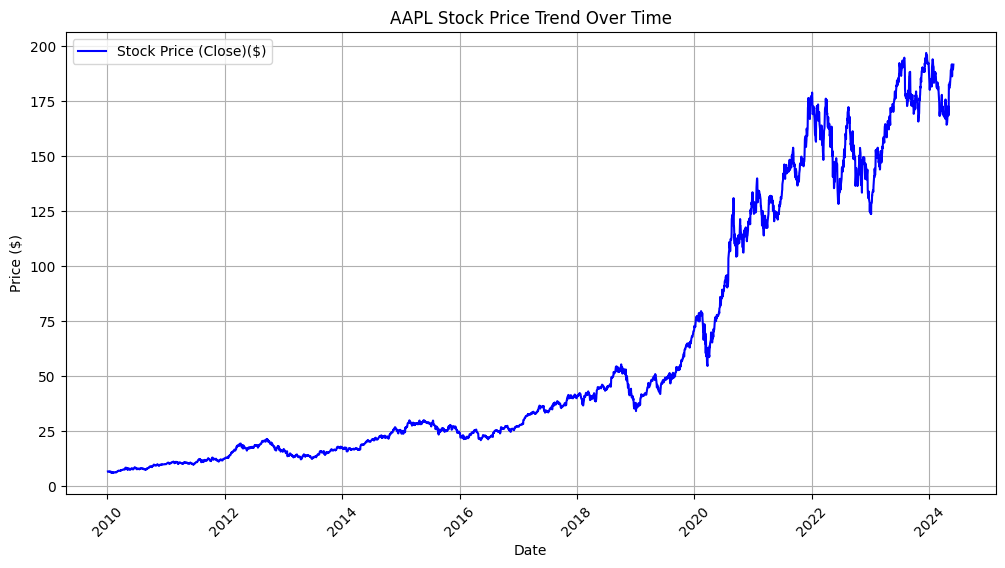

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Close'], label='Stock Price (Close)($)', color='blue')
plt.title('AAPL Stock Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

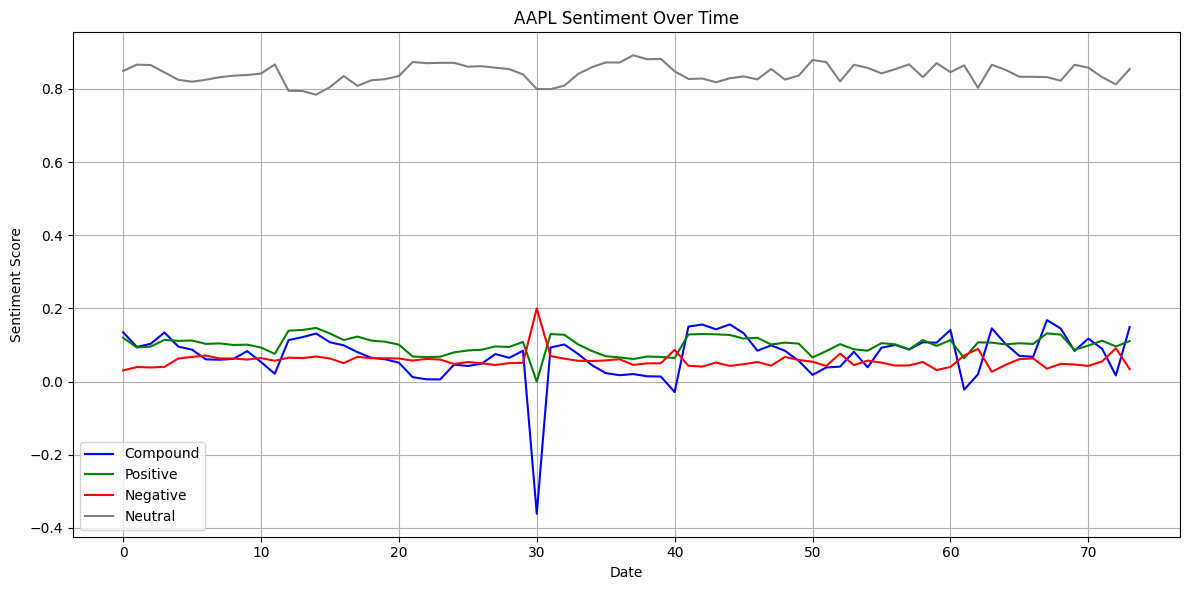

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(sentiment_df['sentiment_compound'], label='Compound', color='blue')
plt.plot(sentiment_df['sentiment_positive'], label='Positive', color='green')
plt.plot(sentiment_df['sentiment_negative'], label='Negative', color='red')
plt.plot(sentiment_df['sentiment_neutral'], label='Neutral', color='gray')
plt.title('AAPL Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
print(merged_df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'EMA_10',
       'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
       'BB_High', 'BB_Low', 'BB_Mid', 'BB_Width', 'Log_Return',
       'Volatility_20', 'sentiment_compound', 'sentiment_positive',
       'sentiment_negative', 'sentiment_neutral'],
      dtype='object')


In [11]:
# Calculate the number of initial rows that will be dropped
initial_rows_before_dropna = len(df)
df.dropna(inplace=True)
num_rows_dropped = initial_rows_before_dropna - len(df)
print(f"Dropped {num_rows_dropped} rows containing NaN values from indicator calculations.")

features = ['Close', 'Volume', 'SMA_10', 'EMA_10', 'SMA_50', 'EMA_50', 'RSI',
            'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low', 'BB_Mid',
            'BB_Width', 'Volatility_20']

# Define features and target
selected_features=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'EMA_10',
       'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
       'BB_High', 'BB_Low', 'BB_Mid', 'BB_Width', 'Log_Return',
       'Volatility_20', 'sentiment_compound', 'sentiment_positive',
       'sentiment_negative', 'sentiment_neutral']


target = 'Close'

Dropped 49 rows containing NaN values from indicator calculations.


In [12]:
# Scale all features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[features].values)

# Create a separate scaler for the target variable (Close price)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(df[[target]].values) 

MinMaxScaler()

In [13]:
# We need to ensure there are enough samples for both train and test, plus look_back_days
if len(scaled_features) <= LOOK_BACK_DAYS + PREDICTION_DAYS+1:
    print(f"Warning: Not enough data for required LOOK_BACK_DAYS ({LOOK_BACK_DAYS}) + PREDICTION_DAYS ({PREDICTION_DAYS}).")
    print(f"Total available data after NA drop: {len(scaled_features)} rows.")
    print("Please increase your START_DATE or reduce LOOK_BACK_DAYS/PREDICTION_DAYS.")
    exit()

# The split point for the features array
split_point_features = len(scaled_features) - PREDICTION_DAYS

if split_point_features < LOOK_BACK_DAYS:
     print(f"Error: Not enough data to create training sequences. Split point ({split_point_features}) is less than LOOK_BACK_DAYS ({LOOK_BACK_DAYS}).")
     print("Adjust START_DATE, END_DATE, LOOK_BACK_DAYS, or PREDICTION_DAYS.")
     exit()

train_data_scaled = scaled_features[0:split_point_features, :]
test_data_scaled = scaled_features[split_point_features - LOOK_BACK_DAYS:, :]

In [14]:
def create_sequences_multifeature(data, target_index_in_data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :]) 
        y.append(data[i, target_index_in_data]) # Predict target for the next day
    return np.array(X), np.array(y)

# Get the index of the 'Close' price in our `features` list
target_feature_index = features.index(target)

X_train, y_train_unshaped = create_sequences_multifeature(train_data_scaled, target_feature_index, LOOK_BACK_DAYS)
X_test, y_test_unshaped = create_sequences_multifeature(test_data_scaled, target_feature_index, LOOK_BACK_DAYS)

X_train = X_train.astype(np.float32)
y_train_scaled = y_train_unshaped.reshape(-1, 1).astype(np.float32)
X_test = X_test.astype(np.float32)
y_test_scaled = y_test_unshaped.reshape(-1, 1).astype(np.float32)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test_scaled.shape}")

X_train shape: (3488, 60, 15)
y_train shape: (3488, 1)
X_test shape: (30, 60, 15)
y_test shape: (30, 1)


In [15]:
if X_train.shape[0] == 0 or X_train.shape[1] == 0 or X_train.shape[2] == 0:
    print(f"Error: X_train has a zero dimension (shape={X_train.shape}). Check data slicing and LOOK_BACK_DAYS.")
    exit()
if y_train_unshaped.shape[0] == 0:
    print(f"Error: y_train_unshaped has 0 samples (shape={y_train_unshaped.shape}). Check data slicing and LOOK_BACK_DAYS.")
    exit()
if X_test.shape[0] == 0 or X_test.shape[1] == 0 or X_test.shape[2] == 0:
    print(f"Error: X_test has a zero dimension (shape={X_test.shape}). Check data slicing and LOOK_BACK_DAYS/PREDICTION_DAYS.")
    exit()
if y_test_unshaped.shape[0] == 0:
    print(f"Error: y_test_unshaped has 0 samples (shape={y_test_unshaped.shape}). Check data slicing and LOOK_BACK_DAYS/PREDICTION_DAYS.")
    exit()

print(f"Final shape of X_train for model: {X_train.shape}")
print(f"Final shape of y_train_scaled for model: {y_train_scaled.shape}")
print(f"Final shape of X_test for model: {X_test.shape}")
print(f"Final shape of y_test_scaled for model: {y_test_scaled.shape}")
print(f"Dtype of X_train: {X_train.dtype}")
print(f"Dtype of y_train_scaled: {y_train_scaled.dtype}")

Final shape of X_train for model: (3488, 60, 15)
Final shape of y_train_scaled for model: (3488, 1)
Final shape of X_test for model: (30, 60, 15)
Final shape of y_test_scaled for model: (30, 1)
Dtype of X_train: float32
Dtype of y_train_scaled: float32


In [16]:
# --- 4. Build the CNN + Bi-LSTM Model ---
print("Building CNN+Bi-LSTM model...")
model = Sequential()
model.add(Conv1D(filters=CNN_FILTERS, kernel_size=CNN_KERNEL_SIZE, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2]))) # (timesteps, features)
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(DROPOUT_RATE))

model.add(Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True)))
model.add(Dropout(DROPOUT_RATE))
model.add(Bidirectional(LSTM(units=LSTM_UNITS)))
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

model.summary()


Building CNN+Bi-LSTM model...


c:\Users\praka\Desktop\git_stock\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 29, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,445 (427.52 KB)

 Trainable params: 109,445 (427.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""# --- 5. Train the Model ---
print("\nTraining the model...")

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=PATIENCE,   # Stop if val_loss doesn't improve for this many epochs
    min_delta=MIN_DELTA, # Minimum change to be considered an improvement
    mode='min',          # Look for minimum val_loss
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity.
    verbose=1
)

history = model.fit(X_train, y_train_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
                    validation_split=0.1, # Using 10% of training data for validation
                    callbacks=[early_stopping]) # Add the early stopping callback

print("\nSaving the trained model and scalers...")
model.save(MODEL_SAVE_PATH)
joblib.dump(scaler, SCALER_SAVE_PATH)
joblib.dump(target_scaler, TARGET_SCALER_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")
print(f"Feature Scaler saved to: {SCALER_SAVE_PATH}")
print(f"Target Scaler saved to: {TARGET_SCALER_SAVE_PATH}")"""


Training the model...
Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0011 - val_loss: 0.0067
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 8.6579e-04 - val_loss: 0.0013
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 9.6694e-04 - val_loss: 0.0012
Epoch 12/100
99/99 ━━


Evaluating model performance on the test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Root Mean Squared Error (RMSE): 5.62
Mean Absolute Error (MAE): 4.71


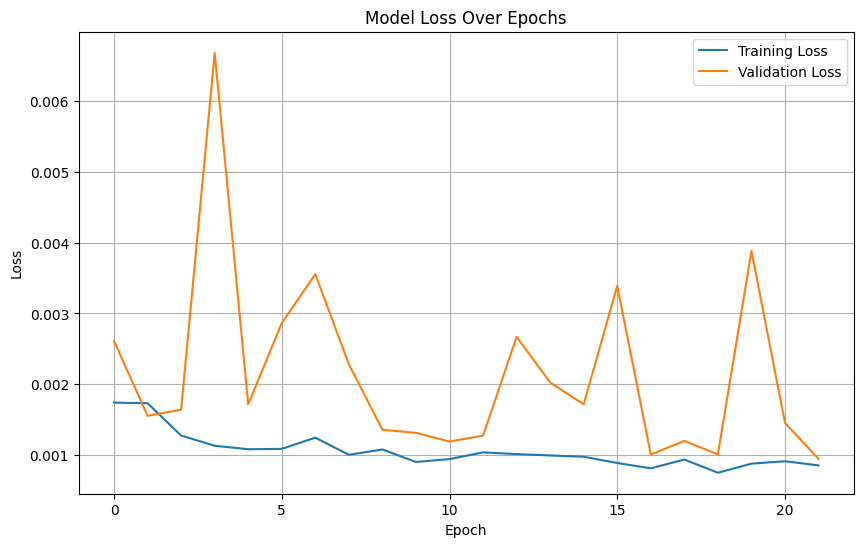

In [ ]:
"""# --- 7. Model Evaluation ---
print("\nEvaluating model performance on the test set...")
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
y_test_original = target_scaler.inverse_transform(y_test_scaled)
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# --- Plotting Training History (Loss) ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()"""


In [26]:
loaded_model = load_model(MODEL_SAVE_PATH)
loaded_scaler = joblib.load(SCALER_SAVE_PATH)
loaded_target_scaler = joblib.load(TARGET_SCALER_SAVE_PATH)
print("\nEvaluating model performance on the test set...")
y_pred_scaled = loaded_model.predict(X_test)

# Inverse transform predictions and actual values to original scale
y_test_original = loaded_target_scaler.inverse_transform(y_test_scaled)
y_pred_original = loaded_target_scaler.inverse_transform(y_pred_scaled)

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Evaluating model performance on the test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
Root Mean Squared Error (RMSE): 5.62
Mean Absolute Error (MAE): 4.71



--- Making Predictions for N Future Days ---
Model and scalers loaded successfully for N-day prediction.

Starting iterative prediction for 150 days...


[*********************100%***********************]  1 of 1 completed



--- N-Day Predictions ---
Date: 2024-06-03, Predicted Close Price: $199.17
Date: 2024-06-03, Predicted Close Price: $199.80
Date: 2024-06-03, Predicted Close Price: $199.84
Date: 2024-06-04, Predicted Close Price: $200.57
Date: 2024-06-05, Predicted Close Price: $200.69
Date: 2024-06-06, Predicted Close Price: $201.42
Date: 2024-06-07, Predicted Close Price: $201.51
Date: 2024-06-10, Predicted Close Price: $202.25
Date: 2024-06-10, Predicted Close Price: $202.30
Date: 2024-06-10, Predicted Close Price: $203.04
Date: 2024-06-11, Predicted Close Price: $203.06
Date: 2024-06-12, Predicted Close Price: $203.66
Date: 2024-06-13, Predicted Close Price: $203.82
Date: 2024-06-14, Predicted Close Price: $204.21
Date: 2024-06-17, Predicted Close Price: $204.33
Date: 2024-06-17, Predicted Close Price: $204.65
Date: 2024-06-17, Predicted Close Price: $204.70
Date: 2024-06-18, Predicted Close Price: $205.03
Date: 2024-06-19, Predicted Close Price: $205.04
Date: 2024-06-20, Predicted Close Price: $

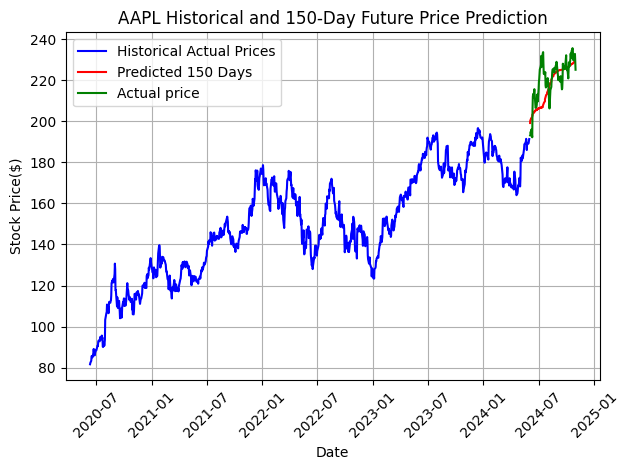


N-day prediction process complete.


In [23]:
# --- 8. Make Predictions on N Future Days (Iterative Prediction) ---
print("\n--- Making Predictions for N Future Days ---")

N_DAYS_TO_PREDICT = 150 


# Load the saved model and scalers
try:
    loaded_model = load_model(MODEL_SAVE_PATH)
    loaded_scaler = joblib.load(SCALER_SAVE_PATH)
    loaded_target_scaler = joblib.load(TARGET_SCALER_SAVE_PATH)
    print("Model and scalers loaded successfully for N-day prediction.")
except Exception as e:
    print(f"Error loading model or scalers for N-day prediction: {e}")
    print("Please ensure the model and scaler files exist at the specified paths.")
    exit()
PREDICTION_ADJUSTMENT = 9

# Get the index of the 'Close' feature in your 'features' list
close_feature_idx = features.index('Close')
num_features = len(features) # Number of features used by the model

# --- Prepare a dynamic DataFrame for historical + predicted data ---
MAX_INDICATOR_WINDOW = 50 

close_prices_history = df['Close'].tail(MAX_INDICATOR_WINDOW + LOOK_BACK_DAYS).tolist()
all_features_history = df[features].tail(MAX_INDICATOR_WINDOW + LOOK_BACK_DAYS).values.tolist()

if len(all_features_history) < (MAX_INDICATOR_WINDOW + LOOK_BACK_DAYS):
    print(f"Error: Not enough historical data ({len(all_features_history)} rows) to form a sequence of {LOOK_BACK_DAYS} for N-day prediction and calculate indicators (need at least {MAX_INDICATOR_WINDOW + LOOK_BACK_DAYS} rows).")
    print("Please ensure your 'df' has enough entries after feature engineering and NaN drops, or adjust START_DATE.")
    exit()

future_predictions_original_scale = []
predicted_dates = []

# Get the last date from the original DataFrame
last_actual_date = df.index[-1]

print(f"\nStarting iterative prediction for {N_DAYS_TO_PREDICT} days...")

# Store the last actual ratios for Open, High, Low, Volume relative to Close
last_actual_open_ratio = df['Open'].iloc[-1] / df['Close'].iloc[-1]
last_actual_high_ratio = df['High'].iloc[-1] / df['Close'].iloc[-1]
last_actual_low_ratio = df['Low'].iloc[-1] / df['Close'].iloc[-1]
last_actual_volume = df['Volume'].iloc[-1]


for i in range(N_DAYS_TO_PREDICT):
    # Determine the date for this prediction, skipping weekends
    next_date_dt = last_actual_date + pd.Timedelta(days=i+1)
    while next_date_dt.weekday() >= 5: # Monday = 0, Sunday = 6
        next_date_dt += pd.Timedelta(days=1)
    predicted_dates.append(next_date_dt.strftime('%Y-%m-%d'))

    # --- Step 1: Extract the relevant `LOOK_BACK_DAYS` of features for the model input ---
    input_sequence_for_prediction = all_features_history[-LOOK_BACK_DAYS:]
    
    input_sequence_np = np.array(input_sequence_for_prediction).astype(np.float32)
    scaled_input_sequence = loaded_scaler.transform(input_sequence_np)
    model_input = scaled_input_sequence.reshape(1, LOOK_BACK_DAYS, num_features)

    # Make the prediction (output will be scaled)
    scaled_prediction = loaded_model.predict(model_input, verbose=0)

    # Inverse transform the prediction to get the price in original scale
    predicted_close_original = loaded_target_scaler.inverse_transform(scaled_prediction)[0][0]
    
    # --- NEW: Add the constant adjustment here ---
    predicted_close_adjusted = predicted_close_original + PREDICTION_ADJUSTMENT
    
    # Store the adjusted prediction
    future_predictions_original_scale.append(predicted_close_adjusted)

    # --- Step 2: Prepare the input sequence for the NEXT prediction step ---
    # Use the ADJUSTED prediction for calculating new indicators and for the next input sequence
    close_prices_history.append(predicted_close_adjusted)
    close_prices_history = close_prices_history[-(MAX_INDICATOR_WINDOW + LOOK_BACK_DAYS):]

    temp_close_series = pd.Series(close_prices_history)

    next_day_features_dict = {}
    next_day_features_dict['Close'] = predicted_close_adjusted # Use adjusted close here
    next_day_features_dict['Open'] = predicted_close_adjusted * last_actual_open_ratio
    next_day_features_dict['High'] = predicted_close_adjusted * last_actual_high_ratio
    next_day_features_dict['Low'] = predicted_close_adjusted * last_actual_low_ratio
    next_day_features_dict['Volume'] = last_actual_volume

    # Recalculate Technical Indicators on the current `temp_close_series`
    next_day_features_dict['SMA_10'] = ta.trend.sma_indicator(temp_close_series, window=10).iloc[-1]
    next_day_features_dict['EMA_10'] = ta.trend.ema_indicator(temp_close_series, window=10).iloc[-1]
    next_day_features_dict['SMA_50'] = ta.trend.sma_indicator(temp_close_series, window=50).iloc[-1]
    next_day_features_dict['EMA_50'] = ta.trend.ema_indicator(temp_close_series, window=50).iloc[-1]

    next_day_features_dict['RSI'] = ta.momentum.rsi(temp_close_series, window=14).iloc[-1]

    macd_val = ta.trend.macd(temp_close_series).iloc[-1]
    macd_signal_val = ta.trend.macd_signal(temp_close_series).iloc[-1]
    macd_diff_val = ta.trend.macd_diff(temp_close_series).iloc[-1]
    next_day_features_dict['MACD'] = macd_val
    next_day_features_dict['MACD_Signal'] = macd_signal_val
    next_day_features_dict['MACD_Diff'] = macd_diff_val

    bollinger = ta.volatility.BollingerBands(temp_close_series, window=20, window_dev=2)
    next_day_features_dict['BB_High'] = bollinger.bollinger_hband().iloc[-1]
    next_day_features_dict['BB_Low'] = bollinger.bollinger_lband().iloc[-1]
    next_day_features_dict['BB_Mid'] = bollinger.bollinger_mavg().iloc[-1]
    next_day_features_dict['BB_Width'] = bollinger.bollinger_wband().iloc[-1]

    temp_log_return = np.log(temp_close_series / temp_close_series.shift(1))
    next_day_features_dict['Log_Return'] = temp_log_return.iloc[-1]
    next_day_features_dict['Volatility_20'] = temp_log_return.rolling(window=20).std().iloc[-1]
    
    new_feature_vector = [next_day_features_dict[feat] for feat in features]

    all_features_history.pop(0)
    all_features_history.append(new_feature_vector)
    
data_actual = yf.download(STOCK_TICKER, start='2024-06-02', end='2024-11-01')

print("\n--- N-Day Predictions ---")
for date, price in zip(predicted_dates, future_predictions_original_scale):
    print(f"Date: {date}, Predicted Close Price: ${price:.2f}")

# Optional: Plot the future predictions alongside historical data
num_plot_history = 1000 
historical_dates_for_plot = df.index[-num_plot_history:].tolist()
historical_prices_for_plot = df['Close'].tail(num_plot_history).tolist()

plt.plot(historical_dates_for_plot, historical_prices_for_plot, label='Historical Actual Prices', color='blue')
plt.plot(pd.to_datetime(predicted_dates), future_predictions_original_scale, label=f'Predicted {N_DAYS_TO_PREDICT} Days', color='red')
plt.plot(data_actual.index,data_actual['Close'],label='Actual price',color='green')
plt.title(f'{STOCK_TICKER} Historical and {N_DAYS_TO_PREDICT}-Day Future Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nN-day prediction process complete.")

